In [29]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

%matplotlib inline
sns.set()
# its possible to look at Confirmed,Recovered or Deaths simply by changing the filename below
# assign either of ['Confirmed','Deaths','Recovered'] to param below:

param = 'Confirmed'

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-' + param + '.csv',
                sep=',',encoding='ISO8859-1')
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,36,50,50,83,93,99,117,129,149,149


In [30]:
country_list = sorted(df_confirmed['Country/Region'].unique())
#country_list


In [31]:
countries = df_confirmed.groupby('Country/Region')
country_increase = pd.DataFrame(countries.sum().iloc[:,-1] - countries.sum().iloc[:,-2],columns=['increase'])
country_increase['today'] = countries.sum().iloc[:,-1]
country_increase['previous_day'] = countries.sum().iloc[:,-2]
country_increase['factor'] = countries.sum().iloc[:,-1] / countries.sum().iloc[:,-2]
country_increase['factor'] = country_increase['factor'].replace(np.inf,np.nan)
country_increase.sort_values(by='increase',ascending=False,inplace=True)
country_increase = country_increase[['previous_day','today','increase','factor']]
country_increase.head(40)
                                                                    

,previous_day,today,increase,factor
Country/Region,,,,
Iran,9000,10075,1075,1.119444
US,1281,1663,382,1.298205
Denmark,444,617,173,1.389640
Germany,1908,2078,170,1.089099
"Korea, South",7755,7869,114,1.014700
Norway,598,702,104,1.173913
Sweden,500,599,99,1.198000
Austria,246,302,56,1.227642
Slovenia,57,89,32,1.561404


In [32]:
country_increase[['previous_day','today','increase']].sum()

previous_day    125865
today           128343
increase          2478
dtype: int64

In [33]:
country_increase.describe()

,previous_day,today,increase,factor
count,116.000000,116.000000,116.000000,114.000000
mean,1085.043103,1106.405172,21.362069,1.162761
std,7648.130963,7660.019177,108.287010,0.387282
min,0.000000,1.000000,0.000000,1.000000
25%,3.750000,4.000000,0.000000,1.000000
50%,14.500000,19.000000,0.000000,1.000000
75%,72.500000,86.000000,4.000000,1.176543
max,80921.000000,80932.000000,1075.000000,4.000000


/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecatio

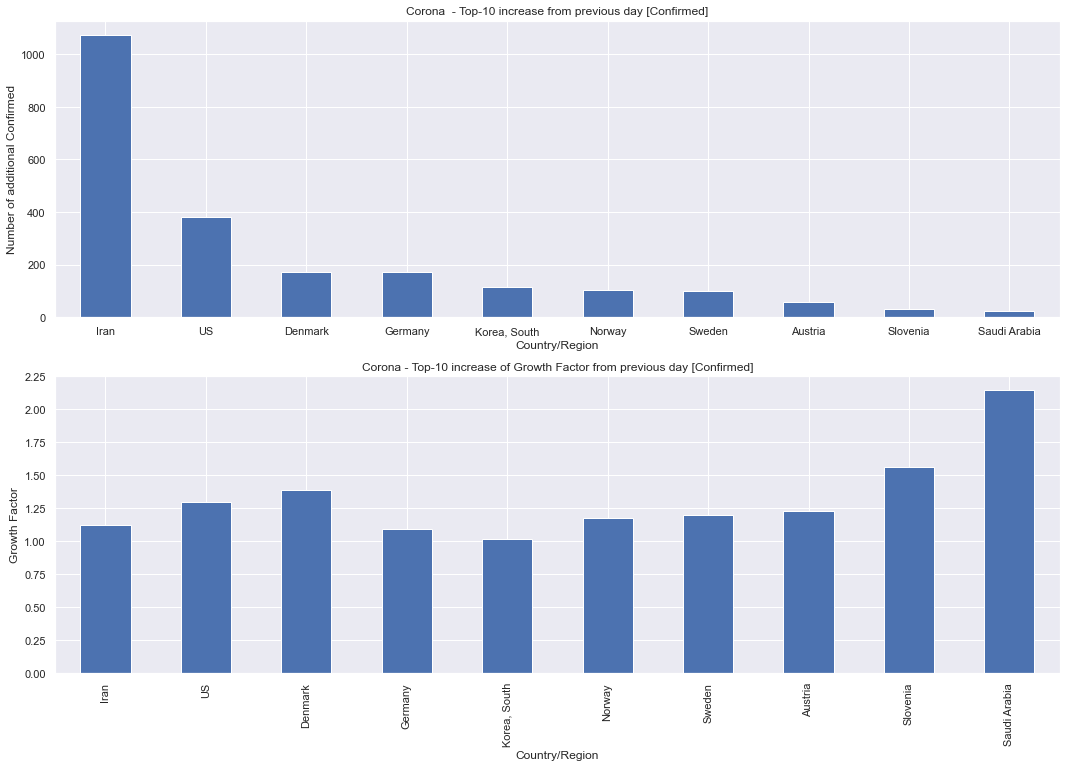

In [34]:
# pandas plot generates a warning about depreciated feature. Nothing to do bout it, it's pandas internal
plt.figure(figsize=(18,12))
plt.subplot(211)
plt.title('Corona  - Top-10 increase from previous day [{}]'.format(param))
plt.ylabel('Number of additional ' + param)
country_increase['increase'][:10].plot(kind='bar')
plt.xticks(rotation=0)
plt.subplot(212)
plt.title('Corona - Top-10 increase of Growth Factor from previous day [{}]'.format(param))
plt.ylabel('Growth Factor')
country_increase['factor'][:10].plot(kind='bar')
plt.savefig('top_10_daily_growth.jpg',format='jpg')

In [35]:
my_countries = ['Italy','Spain','US','Sweden','Finland','Norway','Denmark']

mask = country_increase['increase'] == 0
#zero_growth = country_increase[mask]
#ero_growth
country_increase.loc[my_countries].sort_values('increase')

,previous_day,today,increase,factor
Country/Region,,,,
Italy,12462,12462,0,1.000000
Spain,2277,2277,0,1.000000
Finland,59,59,0,1.000000
Sweden,500,599,99,1.198000
Norway,598,702,104,1.173913
Denmark,444,617,173,1.389640
US,1281,1663,382,1.298205


In [49]:
#### SELECT COUNTRY OF INTEREST
#### for other countries, replace the country name in the line below ###
####

country_of_interest = 'Iran'

####
####

us = countries.get_group(country_of_interest)
us.head()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
157,NaN,32.0,53.0,0,0,0,0,0,0,0,...,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075


In [50]:
us_count = us.iloc[:,4:].sum()
us_count.index = pd.to_datetime(us_count.index)
us_count = pd.DataFrame(us_count,columns=['confirmed'])
us_count['factor'] = us_count['confirmed'] / us_count['confirmed'].shift()
us_count['factor'].replace(np.inf,np.nan)
us_count['day'] = np.arange(1,len(us_count) + 1)
us_count = us_count.loc[us_count['confirmed'] > 0]
us_count['factor'] = us_count['factor'].replace(np.inf,np.nan)
us_count.tail(60)

,confirmed,factor,day
2020-02-19,2,NaN,28
2020-02-20,5,2.500000,29
2020-02-21,18,3.600000,30
2020-02-22,28,1.555556,31
2020-02-23,43,1.535714,32
2020-02-24,61,1.418605,33
2020-02-25,95,1.557377,34
2020-02-26,139,1.463158,35
2020-02-27,245,1.762590,36
2020-02-28,388,1.583673,37


In [38]:
us_count.describe()


,confirmed,factor,day
count,41.000000,40.000000,41.000000
mean,241.365854,1.267506,30.000000
std,570.893631,0.437949,11.979149
min,1.000000,1.000000,10.000000
25%,2.000000,1.000000,20.000000
50%,2.000000,1.000000,30.000000
75%,120.000000,1.382812,40.000000
max,2277.000000,3.000000,50.000000


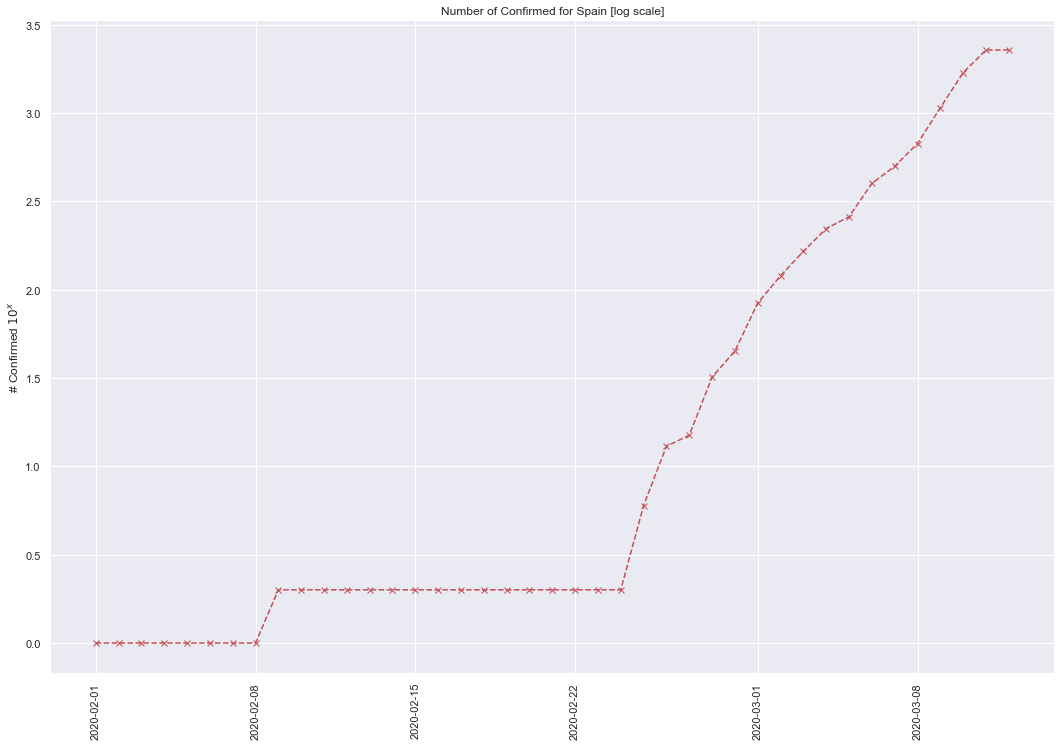

In [39]:
plt.figure(figsize=(18,12))
plt.title('Number of {} for '.format(param) + country_of_interest + ' [log scale]')
plt.plot(np.log10(us_count['confirmed']),'x--',color='r')
plt.ylabel(r'# {} $10^x$'.format(param))
plt.xticks(rotation=90)
plt.savefig('nr_{}_log_'.format(param) + country_of_interest + '.jpg',format='jpg')

In [40]:
factor_mean = us_count['factor'].mean()
factor_std = us_count['factor'].std()
day_mean = us_count['day'].mean()
day_std = us_count['day'].std()

def standardize(x):
    return (x - x.mean()) / x.std()

us_count['day'] = standardize(us_count['day'])
us_count['factor'] = standardize(us_count['factor'])
us_count.tail()

,confirmed,factor,day
2020-03-08,673,0.179230,1.335654
2020-03-09,1073,0.746313,1.419133
2020-03-10,1695,0.712815,1.502611
2020-03-11,2277,0.173208,1.586089
2020-03-12,2277,-0.610816,1.669568


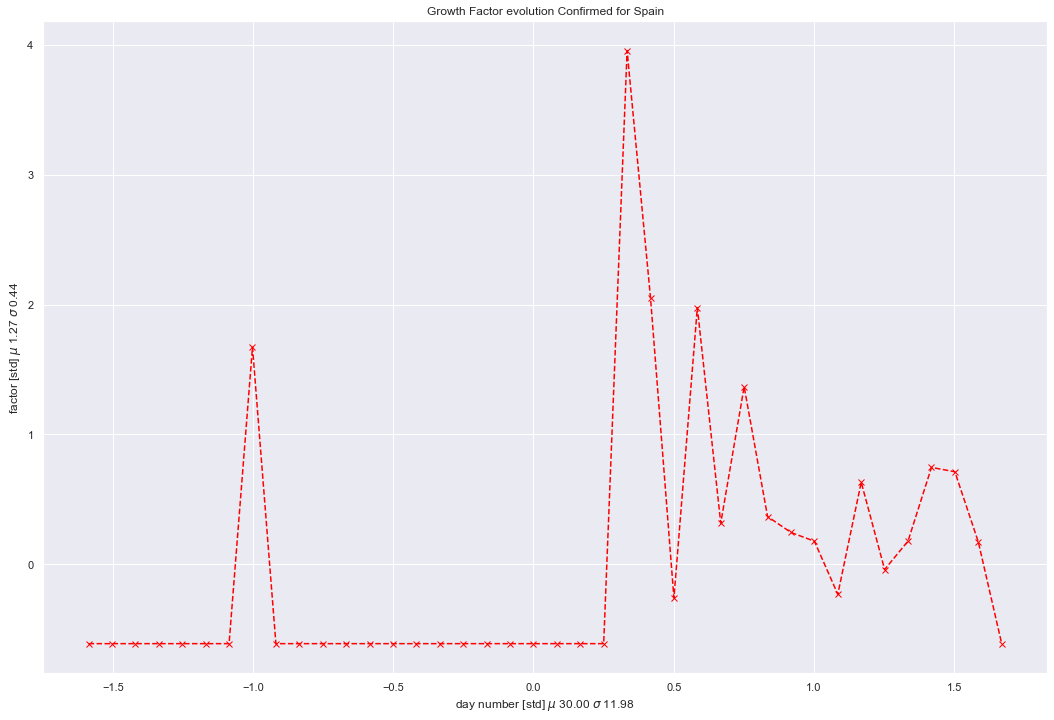

In [41]:
plt.figure(figsize=(18,12))
plt.title('Growth Factor evolution {} for '.format(param) + country_of_interest)
plt.plot(us_count['day'],us_count['factor'],'x--',color='red')
_=plt.xlabel(r'day number [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(day_mean,day_std))
_=plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(factor_mean,factor_std))
plt.savefig('growth_factor_evolution_{}'.format(param) + country_of_interest +'.jpg',format='jpg')

alpha mean 0.01 beta mean 0.01


Text(0.5, 1.0, 'lines simulated from priors')

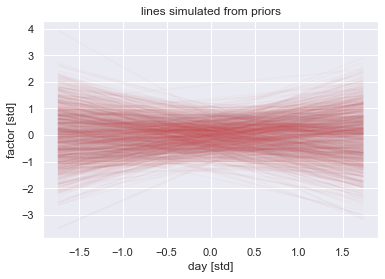

In [42]:
#FIGURE OUT PRIORS by random sampling
# purpose: to see that the priors, before seeing data, produce
# resonable regression lines, i.e. the lines should not extend beyond 3 standard deviations 
# at the y-axis.

def sim_linreq_mu(x,alpha,beta):
    return x * alpha + beta

#SIMULATE priors 
#HYPOTHESIS by looking at graph: 
alpha_mu = 0 #HYPOTHESIS: intercept at 0
alpha_sigma = 0.5
beta_mu = 0 #HYPOTHESIS: slope 0
beta_sigma = 0.5

size = 10000
# simulate priors based on params above
alpha = pm.rnormal(mu = alpha_mu,tau = 1 / alpha_sigma ** 2,size=size)
beta =  pm.rnormal(mu = beta_mu, tau = 1 / beta_sigma ** 2,size=size)

print ('alpha mean {:.2f} beta mean {:.2f}'.format(alpha.mean(),beta.mean()))

# sample simulated priors
nr_rows = 1000
alphas = np.random.choice(alpha,replace=True,size=nr_rows)
betas = np.random.choice(beta,replace=True,size=nr_rows)

# build simulated regression lines
X = np.linspace(min(us_count['day']),max(us_count['day']),nr_rows)
X = standardize(X)
lines = [X[i] * betas + alphas for i in range(len(X))]

_=plt.plot(X,lines,color='r',alpha=0.03)
plt.ylabel('factor [std]')
plt.xlabel('day [std]')
plt.title('lines simulated from priors')


In [43]:
#REGRESSION
alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu, tau = 1/ beta_sigma ** 2)
sigma = pm.Uniform('sigma',lower=0,upper=10)

us_count.dropna(inplace = True) # pymc doesnt like them
x = us_count['day']

@pm.deterministic()
def linreq_mu(x=x,alpha=alpha,beta=beta):
    return x * beta + alpha

likelihood = pm.Normal('likelihood',
                     mu=linreq_mu,
                     tau= 1 / sigma ** 2,
                     observed = True,
                      value=us_count['factor'])

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)
mcmc.sample(10000,5000,2)

alpha_post = mcmc.trace('alpha')[:]
beta_post = mcmc.trace('beta')[:]
sigma_post = mcmc.trace('sigma')[:]
linreq_mu_post = mcmc.trace('linreq_mu')[:,0]

result = pd.DataFrame({'alpha_post':alpha_post,
                       'beta_post':beta_post,
                       'sigma_post':sigma_post,
                       'linreq_mu_post':linreq_mu_post})

result.describe()


 [-----------------100%-----------------] 10000 of 10000 complete in 11.1 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-0.005644,0.354630,0.965601,-0.568119
std,0.145086,0.152564,0.112923,0.289532
min,-0.502531,-0.183245,0.670992,-1.656891
25%,-0.103989,0.253065,0.890064,-0.757754
50%,-0.006554,0.356060,0.951384,-0.571243
75%,0.087257,0.457974,1.035079,-0.381434
max,0.549012,0.910503,1.504048,0.502966


In [44]:
# LEAST SQUARES REGRESSION for comparison
slope,intercept,_,_,_ = sps.linregress(x,us_count['factor'])

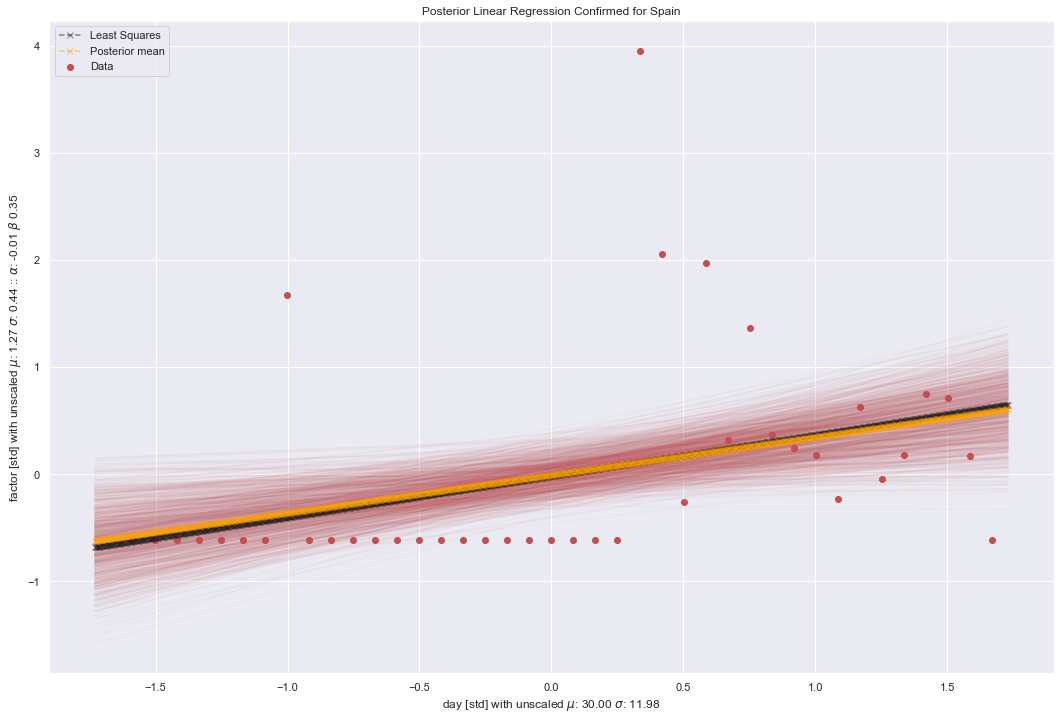

In [45]:
#PLOT POSTERIOR
alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_rows)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_rows)
sigmas = np.random.choice(result['sigma_post'],replace=True,size=nr_rows)

mus = np.array([X[i] * betas + alphas for i in range(len(X))])

lsq_mus = np.array([X[i] * slope + intercept for i in range(len(X))])

plt.figure(figsize=(18,12))
plt.title('Posterior Linear Regression {} for '.format(param) + country_of_interest)
plt.plot(X,mus,color='r',alpha=0.03)
plt.plot(X,lsq_mus,'x--',color='k',label='Least Squares',alpha=0.5)
plt.plot(X,np.array([X[i] * beta_post.mean() + alpha_post.mean() for i in range(len(X))]),
        'x--',color='orange',label='Posterior mean',alpha=0.5)

plt.scatter(us_count['day'],us_count['factor'],color='r',label='Data')

xlabel = r'day [std] with unscaled $\mu$: {:.2f} $\sigma$: {:.2f}'.format(
    day_mean,
    day_std)

ylabel = r'factor [std] with unscaled $\mu$: {:.2f} $\sigma$: {:.2f} :: $\alpha$: {:.2f} $\beta$ {:.2f}'.format(
    factor_mean,
    factor_std,
    alpha_post.mean(),
    beta_post.mean())

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc='upper left')
plt.savefig('linear_regression_{}'.format(param) + country_of_interest +'.jpg',format='jpg')




